# Experiments

In this notebook, I will run some experiments to see how the model performs on different settings.

First, I will train the dataset on a small one layer CNN, medium one layer CNN and three layer CNN.

Another experiment will be to see how the model performs with the laplacian of the images. This operation highlights the edges of the images, which could make the model easier to train.

Finally, I will also try to use the minimum square inside the object.

# Imports

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

LABELS = {0: "Upper part", 1: "Bottom part", 2: "One piece", 3: "Footwear", 4: "Bags"}

# Load data and functions

In [2]:
def load_data():
    """
    Load data from pickle file
    """
    with open('../data/processed/fashion_mnist_k5.pkl', 'rb') as f:
        (train_x, train_y), (test_x, test_y) = pickle.load(f)
        return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = load_data()

In [3]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score


def load_data(path='../data/processed/fashion_mnist_k5.pkl'):
    """
    Load data from pickle file
    """
    with open(path, 'rb') as f:
        (train_x, train_y), (test_x, test_y) = pickle.load(f)
        return train_x, train_y, test_x, test_y
        

def cast_and_normalize_images(train, test):
    """
    Convert from integers to floats and normalize to range 0-1
    """
    # Apply sobel filter
    from scipy import ndimage
    for i in range(train.shape[0]):
        img = train[i, :, :]
        # Change all pixels to 0, 50, 100, 150, 200, 250, 255
        img = np.round(img / 50) * 50
        # Laplace filter
        img = ndimage.laplace(img)
        # Normalize between 0 and 255
        train[i, :, :] = (img - img.min()) / (img.max() - img.min()) * 255
        

    for i in range(test.shape[0]):
        img = test[i, :, :]
        # Change all pixels to 0, 50, 100, 150, 200, 250, 255
        img = np.round(img / 50) * 50
        # Laplace filter
        img = ndimage.laplace(img)
        # Normalize between 0 and 255
        test[i, :, :] = (img - img.min()) / (img.max() - img.min()) * 255

    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    
    return train_norm, test_norm


def get_model():
    """
    Define the CNN model
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    # model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(5, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Epoch 1/16
3000/3000 [==============================] - 35s 11ms/step - loss: 0.1619 - accuracy: 0.9448 - val_loss: 0.1168 - val_accuracy: 0.9604 - lr: 0.0100
Epoch 2/16
3000/3000 [==============================] - 33s 11ms/step - loss: 0.0927 - accuracy: 0.9669 - val_loss: 0.1051 - val_accuracy: 0.9642 - lr: 0.0100
Epoch 3/16
3000/3000 [==============================] - 33s 11ms/step - loss: 0.0722 - accuracy: 0.9733 - val_loss: 0.0924 - val_accuracy: 0.9673 - lr: 0.0100
Epoch 4/16
3000/3000 [==============================] - 33s 11ms/step - loss: 0.0568 - accuracy: 0.9795 - val_loss: 0.1083 - val_accuracy: 0.9643 - lr: 0.0100
Epoch 5/16
3000/3000 [==============================] - 33s 11ms/step - loss: 0.0465 - accuracy: 0.9833 - val_loss: 0.0962 - val_accuracy: 0.9682 - lr: 0.0100
Epoch 6/16
3000/3000 [==============================] - 33s 11ms/step - loss: 0.0361 - accuracy: 0.9874 - val_loss: 0.0982 - val_accuracy: 0.9697 - lr: 0.0100
Epoch 7/16
3000/3000 [========================

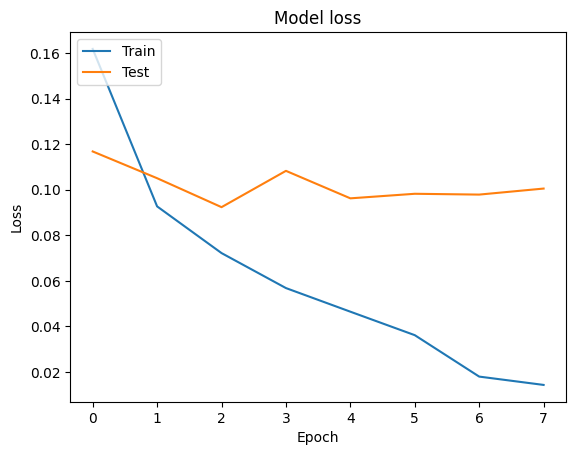

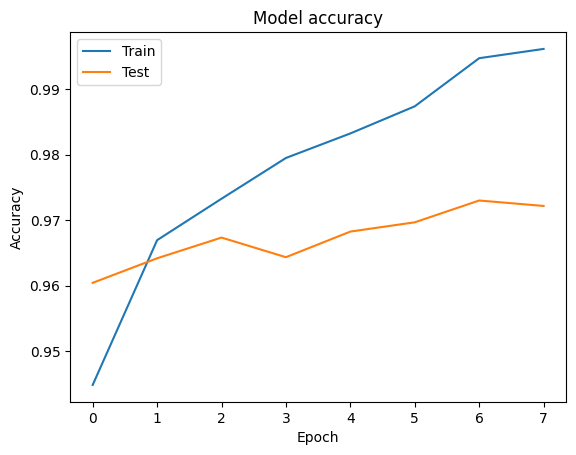

313/313 [==============================] - 2s 6ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4000
           1       0.98      0.98      0.98      1000
           2       0.91      0.87      0.89      1000
           3       1.00      1.00      1.00      3000
           4       0.98      0.96      0.97      1000

    accuracy                           0.97     10000
   macro avg       0.97      0.96      0.96     10000
weighted avg       0.97      0.97      0.97     10000

[[3905    6   73    3   13]
 [   6  978   14    0    2]
 [ 116    9  872    0    3]
 [   1    0    0 2995    4]
 [  24    1    2    9  964]]


In [64]:
train_x, train_y, test_x, test_y = load_data()
train_x, test_x = cast_and_normalize_images(train_x, test_x)
train_x, val_x, train_y, val_y = train_test_split(
    train_x, 
    train_y,
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

# Train model
model = get_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(train_x, train_y, 
          epochs=16, batch_size=16, 
          validation_data=(val_x, val_y), 
        #   class_weight={0: 0.25, 1: 1, 2: 1, 3: 0.333, 4: 1},
          callbacks=[reduce_lr, early_stop], 
          verbose=1)

# Plot loss and accuracy
model_loss = model.history.history['loss']
model_val_loss = model.history.history['val_loss']
plt.plot(model_loss)
plt.plot(model_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/model_loss.png')
plt.show()

model_acc = model.history.history['accuracy']
model_val_acc = model.history.history['val_accuracy']
plt.plot(model_acc)
plt.plot(model_val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/model_acc.png')
plt.show()

# Evaluate model
y_pred = model.predict(test_x)
print(classification_report(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))
print(confusion_matrix(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))


At the end, the results are slightly worse than the original images.

# Bigger model

In [49]:
def get_bigger_model():
    """
    Define the CNN model
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(5, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Epoch 1/16
3000/3000 [==============================] - 18s 6ms/step - loss: 0.2472 - accuracy: 0.9159 - val_loss: 0.1466 - val_accuracy: 0.9507 - lr: 0.0100
Epoch 2/16
3000/3000 [==============================] - 18s 6ms/step - loss: 0.1361 - accuracy: 0.9552 - val_loss: 0.1332 - val_accuracy: 0.9567 - lr: 0.0100
Epoch 3/16
3000/3000 [==============================] - 18s 6ms/step - loss: 0.1165 - accuracy: 0.9607 - val_loss: 0.1274 - val_accuracy: 0.9564 - lr: 0.0100
Epoch 4/16
3000/3000 [==============================] - 18s 6ms/step - loss: 0.1036 - accuracy: 0.9645 - val_loss: 0.1214 - val_accuracy: 0.9602 - lr: 0.0100
Epoch 5/16
3000/3000 [==============================] - 18s 6ms/step - loss: 0.0930 - accuracy: 0.9670 - val_loss: 0.1281 - val_accuracy: 0.9597 - lr: 0.0100
Epoch 6/16
3000/3000 [==============================] - 18s 6ms/step - loss: 0.0851 - accuracy: 0.9697 - val_loss: 0.1303 - val_accuracy: 0.9577 - lr: 0.0100
Epoch 7/16
3000/3000 [==============================

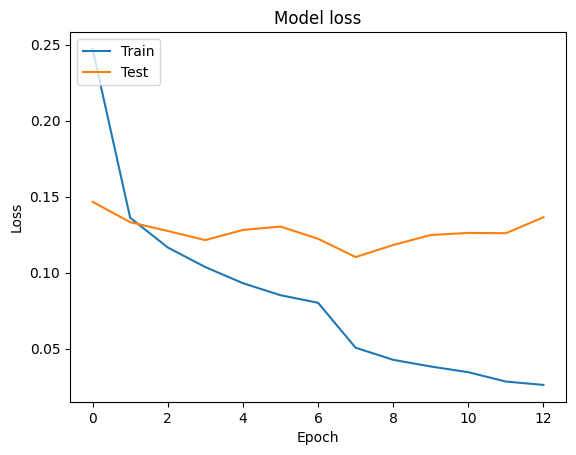

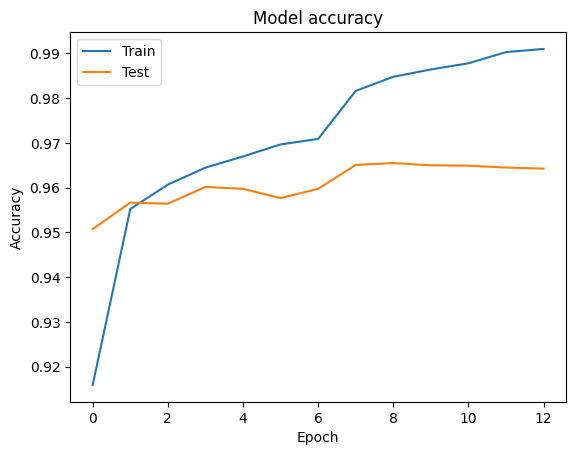

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4000
           1       0.97      0.96      0.96      1000
           2       0.90      0.83      0.87      1000
           3       1.00      1.00      1.00      3000
           4       0.96      0.96      0.96      1000

    accuracy                           0.96     10000
   macro avg       0.95      0.94      0.95     10000
weighted avg       0.96      0.96      0.96     10000

[[3880   14   76    1   29]
 [  26  958   15    0    1]
 [ 144   18  833    1    4]
 [   1    0    2 2991    6]
 [  28    1    0    8  963]]


In [50]:
train_x, train_y, test_x, test_y = load_data()
train_x, test_x = cast_and_normalize_images(train_x, test_x)
train_x, val_x, train_y, val_y = train_test_split(
    train_x, 
    train_y,
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

# Train model
big_model = get_bigger_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

big_model.fit(train_x, train_y, 
          epochs=16, batch_size=16, 
          validation_data=(val_x, val_y), 
        #   class_weight={0: 0.25, 1: 1, 2: 1, 3: 0.333, 4: 1},
          callbacks=[reduce_lr, early_stop], 
          verbose=1)

# Plot loss and accuracy
big_model_loss = big_model.history.history['loss']
big_model_val_loss = big_model.history.history['val_loss']
plt.plot(big_model_loss)
plt.plot(big_model_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/big_model_loss.png')
plt.show()

big_model_acc = big_model.history.history['accuracy']
big_model_val_acc = big_model.history.history['val_accuracy']
plt.plot(big_model_acc)
plt.plot(big_model_val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/big_model_acc.png')
plt.show()

# Evaluate model
y_pred = big_model.predict(test_x)
print(classification_report(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))
print(confusion_matrix(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))


# Small model

In [51]:
def get_small_model():
    """
    Define the CNN model
    """
    model = Sequential()
    model.add(Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(5, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [52]:
train_x, train_y, test_x, test_y = load_data()
train_x, test_x = cast_and_normalize_images(train_x, test_x)
train_x, val_x, train_y, val_y = train_test_split(
    train_x, 
    train_y,
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

# Train model
small_model = get_small_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

small_model.fit(train_x, train_y, 
          epochs=16, batch_size=16, 
          validation_data=(val_x, val_y), 
        #   class_weight={0: 0.25, 1: 1, 2: 1, 3: 0.333, 4: 1},
          callbacks=[reduce_lr, early_stop], 
          verbose=1)

Epoch 1/16
3000/3000 [==============================] - 10s 3ms/step - loss: 0.2106 - accuracy: 0.9279 - val_loss: 0.1458 - val_accuracy: 0.9507 - lr: 0.0100
Epoch 2/16
3000/3000 [==============================] - 9s 3ms/step - loss: 0.1350 - accuracy: 0.9530 - val_loss: 0.1313 - val_accuracy: 0.9532 - lr: 0.0100
Epoch 3/16
3000/3000 [==============================] - 9s 3ms/step - loss: 0.1165 - accuracy: 0.9589 - val_loss: 0.1277 - val_accuracy: 0.9578 - lr: 0.0100
Epoch 4/16
3000/3000 [==============================] - 9s 3ms/step - loss: 0.1027 - accuracy: 0.9641 - val_loss: 0.1344 - val_accuracy: 0.9542 - lr: 0.0100
Epoch 5/16
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0947 - accuracy: 0.9656 - val_loss: 0.1288 - val_accuracy: 0.9591 - lr: 0.0100
Epoch 6/16
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0853 - accuracy: 0.9697 - val_loss: 0.1337 - val_accuracy: 0.9548 - lr: 0.0100
Epoch 7/16
3000/3000 [==============================] - 9

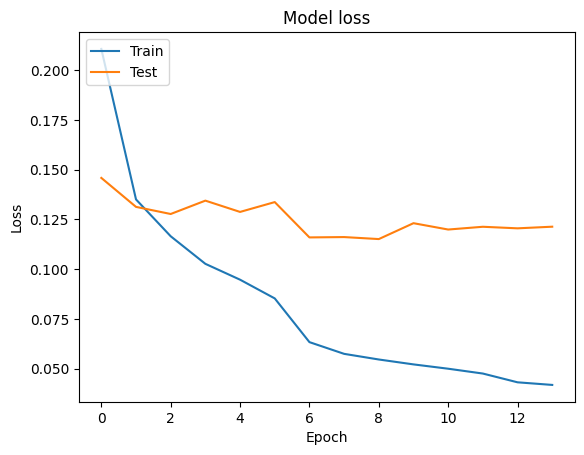

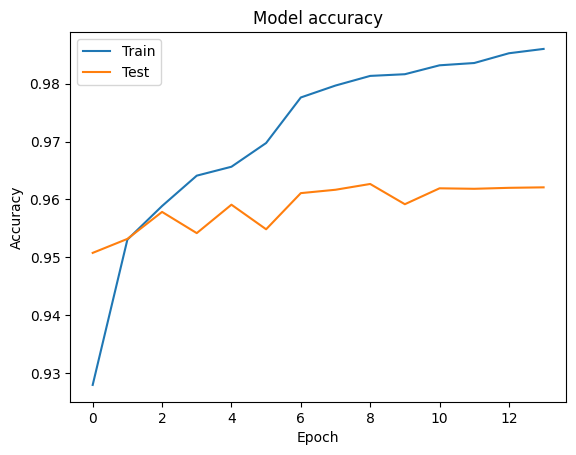

In [53]:
# Plot loss and accuracy
small_model_loss = small_model.history.history['loss']
small_model_val_loss = small_model.history.history['val_loss']
plt.plot(small_model_loss)
plt.plot(small_model_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/small_model_loss.png')
plt.show()

small_model_acc = small_model.history.history['accuracy']
small_model_val_acc = small_model.history.history['val_accuracy']
plt.plot(small_model_acc)
plt.plot(small_model_val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/small_model_acc.png')
plt.show()

In [54]:

# Evaluate model
y_pred = small_model.predict(test_x)
print(classification_report(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))
print(confusion_matrix(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))


313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4000
           1       0.99      0.95      0.97      1000
           2       0.88      0.83      0.86      1000
           3       1.00      1.00      1.00      3000
           4       0.97      0.96      0.96      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.94      0.95     10000
weighted avg       0.96      0.96      0.96     10000

[[3891    1   81    3   24]
 [  16  951   31    0    2]
 [ 154    8  832    1    5]
 [   2    0    0 2996    2]
 [  35    0    1    8  956]]


# 3 plots

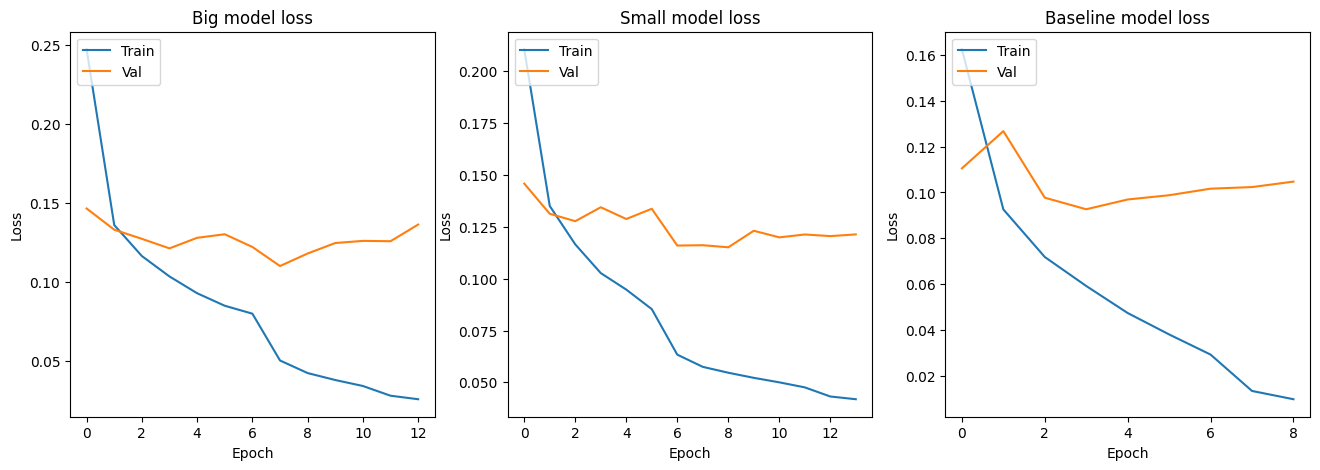

313/313 [==============================] - 1s 2ms/step


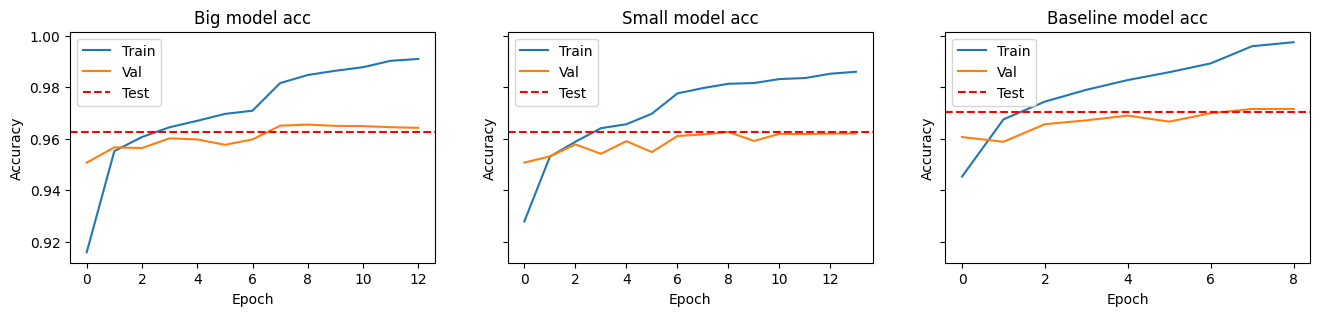

In [55]:
# Plot loss 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

axs[0].plot(big_model_loss)
axs[0].plot(big_model_val_loss)
axs[0].set_title('Big model loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Val'], loc='upper left')
axs[1].plot(small_model_loss)
axs[1].plot(small_model_val_loss)
axs[1].set_title('Small model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Val'], loc='upper left')
axs[2].plot(model_loss)
axs[2].plot(model_val_loss)
axs[2].set_title('Baseline model loss')
axs[2].set_ylabel('Loss')
axs[2].set_xlabel('Epoch')
axs[2].legend(['Train', 'Val'], loc='upper left')

plt.savefig('../plots/loss_3_cnn.png')
plt.show()

# Plot acc 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 3), sharey=True)

axs[0].plot(big_model_acc)
axs[0].plot(big_model_val_acc)
axs[0].set_title('Big model acc')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
y_pred = big_model.predict(test_x)
test_acc = accuracy_score(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1))
axs[0].axhline(y=test_acc, color='r', linestyle='--')
axs[0].legend(['Train', 'Val', 'Test'], loc='upper left')

axs[1].plot(small_model_acc)
axs[1].plot(small_model_val_acc)
axs[1].set_title('Small model acc')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
y_pred = small_model.predict(test_x)
test_acc = accuracy_score(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1))
axs[1].axhline(y=test_acc, color='r', linestyle='--')
axs[1].legend(['Train', 'Val', 'Test'], loc='upper left')

axs[2].plot(model_acc)
axs[2].plot(model_val_acc)
axs[2].set_title('Baseline model acc')
axs[2].set_ylabel('Accuracy')
axs[2].set_xlabel('Epoch')
y_pred = model.predict(test_x)
test_acc = accuracy_score(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1))
axs[2].axhline(y=test_acc, color='r', linestyle='--')
axs[2].legend(['Train', 'Val', 'Test'], loc='upper left')


plt.savefig('../plots/accuracy_3_cnn.png')
plt.show()

# Train with Laplacian of the image

The laplacian of an image is the second derivative of it and it highlights the edges of the image.

I have an intuition that it could help on the classification, so I will try to train the model with it.

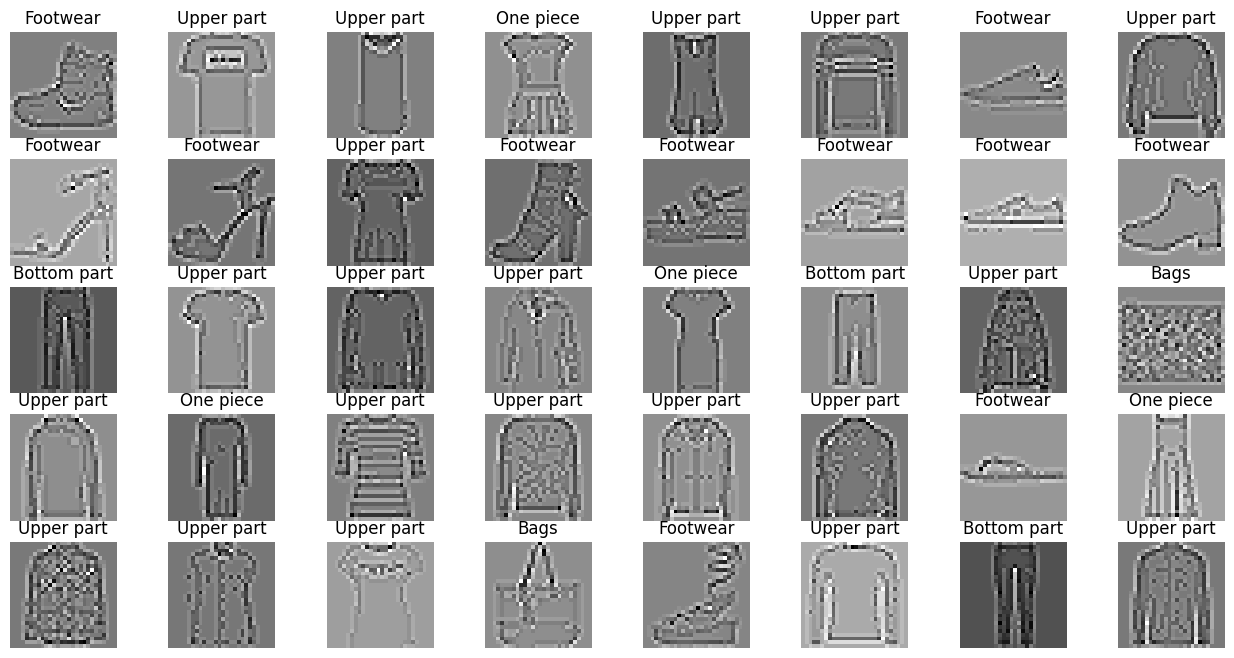

In [61]:
train_x, train_y, test_x, test_y = load_data()

f, ax = plt.subplots(5,8, figsize=(16,8))

for i, image in enumerate(train_x[:40]):
    image = np.round(image / 50) * 50
    laplacian = ndimage.laplace(image)
    # Normalize between 0 and 255
    laplacian = (laplacian - laplacian.min()) / (laplacian.max() - laplacian.min()) * 255
    ax[i//8, i%8].imshow(laplacian, cmap='gray')
    ax[i//8, i%8].axis('off')
    ax[i//8, i%8].set_title(LABELS[np.argmax(train_y[i])])

plt.show()

In [62]:
# Calculate laplacian
for i, image in enumerate(train_x):
    image = np.round(image / 50) * 50
    laplacian = ndimage.laplace(image)
    # Normalize between 0 and 255
    train_x[i] = (laplacian - laplacian.min()) / (laplacian.max() - laplacian.min()) * 255

for i, image in enumerate(test_x):
    image = np.round(image / 50) * 50
    laplacian = ndimage.laplace(image)
    # Normalize between 0 and 255
    test_x[i] = (laplacian - laplacian.min()) / (laplacian.max() - laplacian.min()) * 255

Epoch 1/16
3000/3000 [==============================] - 13s 4ms/step - loss: 0.1688 - accuracy: 0.9418 - val_loss: 0.1060 - val_accuracy: 0.9647 - lr: 0.0100
Epoch 2/16
3000/3000 [==============================] - 13s 4ms/step - loss: 0.0888 - accuracy: 0.9688 - val_loss: 0.1016 - val_accuracy: 0.9657 - lr: 0.0100
Epoch 3/16
3000/3000 [==============================] - 13s 4ms/step - loss: 0.0694 - accuracy: 0.9754 - val_loss: 0.0876 - val_accuracy: 0.9700 - lr: 0.0100
Epoch 4/16
3000/3000 [==============================] - 13s 4ms/step - loss: 0.0574 - accuracy: 0.9796 - val_loss: 0.0918 - val_accuracy: 0.9708 - lr: 0.0100
Epoch 5/16
3000/3000 [==============================] - 13s 4ms/step - loss: 0.0472 - accuracy: 0.9831 - val_loss: 0.0897 - val_accuracy: 0.9697 - lr: 0.0100
Epoch 6/16
3000/3000 [==============================] - 13s 4ms/step - loss: 0.0366 - accuracy: 0.9875 - val_loss: 0.0924 - val_accuracy: 0.9709 - lr: 0.0100
Epoch 7/16
3000/3000 [==============================

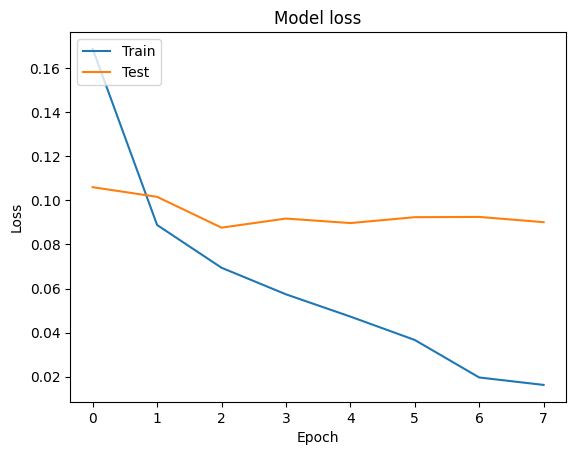

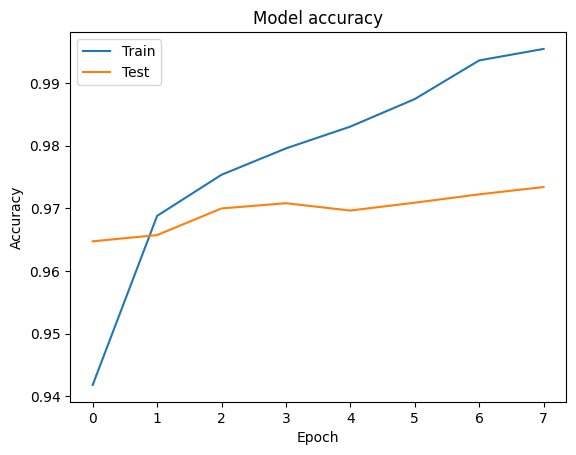

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4000
           1       0.99      0.97      0.98      1000
           2       0.91      0.87      0.89      1000
           3       1.00      1.00      1.00      3000
           4       0.98      0.97      0.97      1000

    accuracy                           0.97     10000
   macro avg       0.97      0.96      0.96     10000
weighted avg       0.97      0.97      0.97     10000

[[3905    6   71    4   14]
 [  12  972   15    0    1]
 [ 120    6  869    1    4]
 [   1    0    0 2997    2]
 [  16    1    4    9  970]]


In [63]:
train_x, train_y, test_x, test_y = load_data()
train_x, test_x = cast_and_normalize_images(train_x, test_x)
train_x, val_x, train_y, val_y = train_test_split(
    train_x, 
    train_y,
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

# Train model
big_model = get_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

big_model.fit(train_x, train_y, 
          epochs=16, batch_size=16, 
          validation_data=(val_x, val_y), 
        #   class_weight={0: 0.25, 1: 1, 2: 1, 3: 0.333, 4: 1},
          callbacks=[reduce_lr, early_stop], 
          verbose=1)

# Plot loss and accuracy
big_model_loss = big_model.history.history['loss']
big_model_val_loss = big_model.history.history['val_loss']
plt.plot(big_model_loss)
plt.plot(big_model_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/big_model_loss.png')
plt.show()

big_model_acc = big_model.history.history['accuracy']
big_model_val_acc = big_model.history.history['val_accuracy']
plt.plot(big_model_acc)
plt.plot(big_model_val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/big_model_acc.png')
plt.show()

# Evaluate model
y_pred = big_model.predict(test_x)
print(classification_report(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))
print(confusion_matrix(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))


The results are very similar as the original images.

# Largest interior rectangle

In [67]:
# !pip install largestinteriorrectangle

Defaulting to user installation because normal site-packages is not writeable


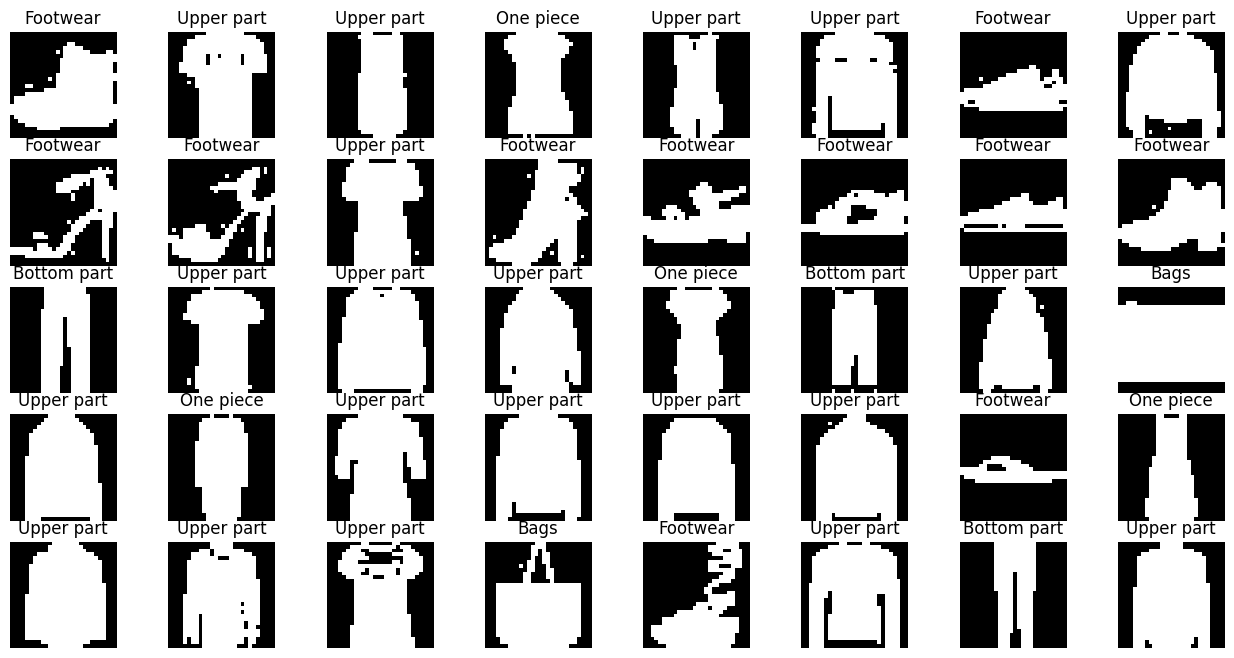

In [4]:
train_x, train_y, test_x, test_y = load_data()

f, ax = plt.subplots(5,8, figsize=(16,8))

for i, image in enumerate(train_x[:40]):
    image = (image > 5) * 255
    ax[i//8, i%8].imshow(image, cmap='gray')
    ax[i//8, i%8].axis('off')
    ax[i//8, i%8].set_title(LABELS[np.argmax(train_y[i])])

plt.show()

/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


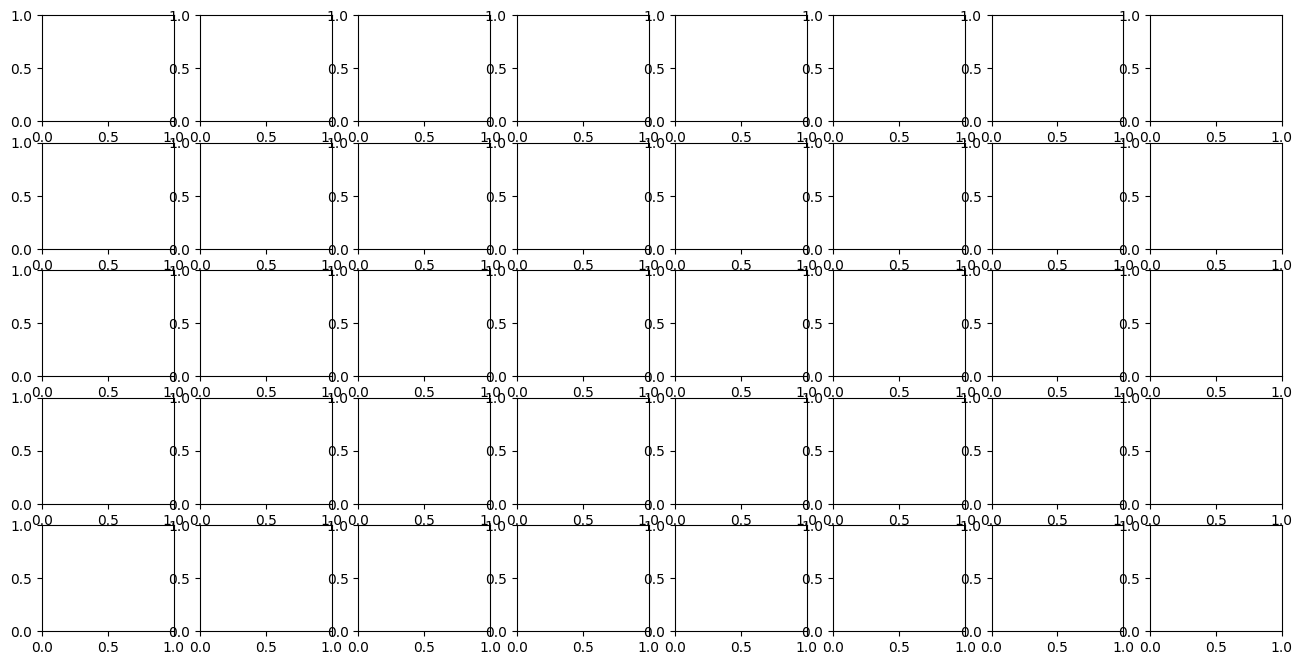

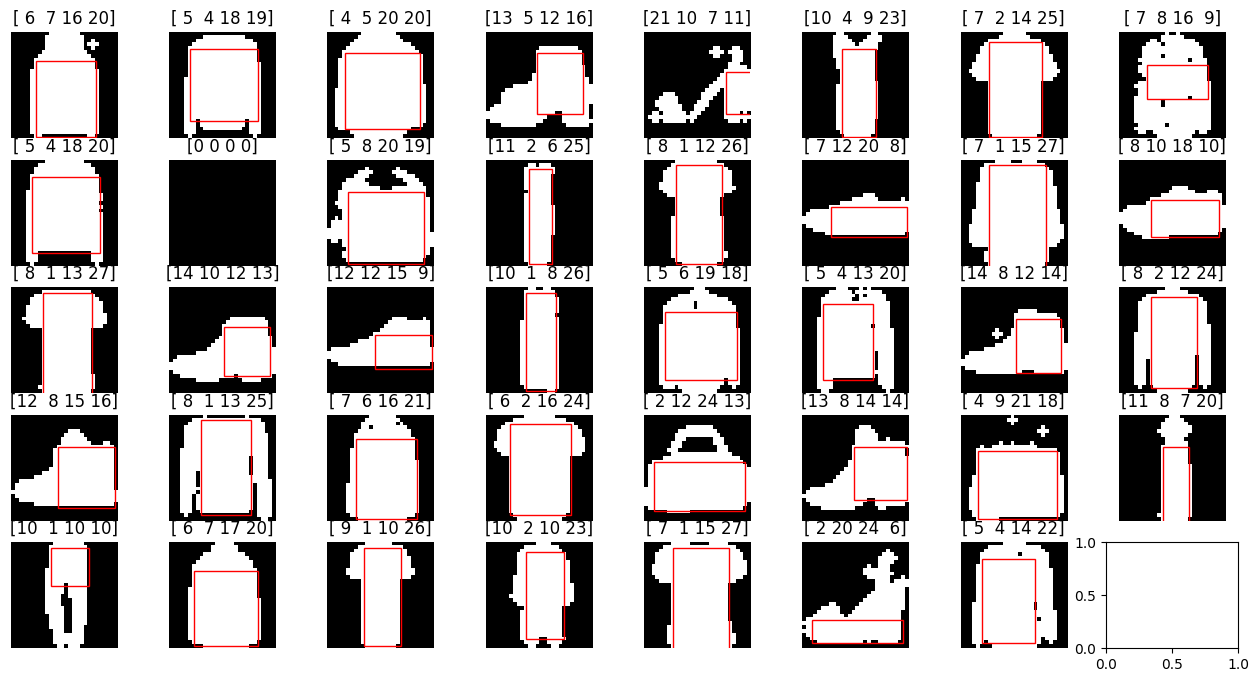

In [44]:
import largestinteriorrectangle as lir
from matplotlib import patches

train_x, train_y, test_x, test_y = load_data()

f, ax = plt.subplots(5,8, figsize=(16,8))

for i, image in enumerate(train_x[39000:39039]):
    image = image.reshape((28, 28))
    image = (image > 0) * 1
    # Opening operation
    image = ndimage.binary_opening(image, iterations=1)

    rect_points = lir.lir(image)
    ax[i//8, i%8].imshow(image, cmap='gray')
    ax[i//8, i%8].axis('off')
    ax[i//8, i%8].set_title(rect_points)
    # ax[i//8, i%8].set_title(LABELS[np.argmax(train_y[i])])
    # Draw rectangle
    rect = patches.Rectangle((rect_points[0], rect_points[1]), rect_points[2], rect_points[3], linewidth=1, edgecolor='r', facecolor='none')
    ax[i//8, i%8].add_patch(rect)

plt.show()

In [87]:
import pandas as pd
from tqdm import tqdm

train_x, train_y, test_x, test_y = load_data()

train_data = []
for i, image in tqdm(enumerate(train_x)):
    image = image.reshape((28, 28))
    image = (image > 0) * 1
    # Opening operation
    image = ndimage.binary_opening(image, iterations=1)
    rect_points = lir.lir(image)

    train_data.append(rect_points)

test_data = []
for i, image in tqdm(enumerate(test_x)):
    image = image.reshape((28, 28))
    image = (image > 0) * 1
    # Opening operation
    image = ndimage.binary_opening(image, iterations=1)
    rect_points = lir.lir(image)

    test_data.append(rect_points)

60000it [19:26, 51.42it/s] 
10000it [02:13, 74.81it/s]


In [88]:
# Enter data in df
df = pd.DataFrame(train_data, columns=['x1', 'y1', 'width', 'height'])
# Add column with proportion
df['proportion'] = df['width'] / df['height']


df_test = pd.DataFrame(test_data, columns=['x1', 'y1', 'width', 'height'])
df_test['proportion'] = df_test['width'] / df_test['height']

In [89]:
# Substitue NaN with 0
df = df.fillna(0)

In [90]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(df, np.argmax(train_y, axis=1))

# Evaluate decision tree
y_pred = tree.predict(df_test)
print(classification_report(np.argmax(test_y, axis=1), y_pred))
print(confusion_matrix(np.argmax(test_y, axis=1), y_pred, normalize='true'))

from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
forest.fit(df, np.argmax(train_y, axis=1))

# Evaluate random forest
y_pred = forest.predict(df_test)
print(classification_report(np.argmax(test_y, axis=1), y_pred))
print(confusion_matrix(np.argmax(test_y, axis=1), y_pred, normalize='true'))


              precision    recall  f1-score   support

           0       0.87      0.91      0.89      4000
           1       0.92      0.87      0.90      1000
           2       0.79      0.70      0.74      1000
           3       0.97      0.97      0.97      3000
           4       0.80      0.78      0.79      1000

    accuracy                           0.89     10000
   macro avg       0.87      0.85      0.86     10000
weighted avg       0.89      0.89      0.89     10000

[[0.91375    0.00875    0.0305     0.01       0.037     ]
 [0.079      0.87       0.043      0.003      0.005     ]
 [0.256      0.027      0.698      0.011      0.008     ]
 [0.01233333 0.00166667 0.00566667 0.96933333 0.011     ]
 [0.169      0.004      0.005      0.04       0.782     ]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      4000
           1       0.93      0.88      0.90      1000
           2       0.80      0.71      0.75      1000
   

# Time to predict

In [93]:
%timeit tree.predict(df_test)
%timeit forest.predict(df_test)
%timeit model.predict(test_x, verbose=0)

The slowest run took 5.87 times longer than the fastest. This could mean that an intermediate result is being cached.
6.55 ms ± 3.3 ms per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
707 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.02 s ± 71.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [94]:
sample_df = df.iloc[0].to_frame().T
sample = test_x[0].reshape(1, 28, 28, 1)

%timeit tree.predict(sample_df)
%timeit forest.predict(sample_df)
%timeit model.predict(sample, verbose=0)

2.79 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
33.3 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
159 ms ± 3.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Conclusions